# 信号処理-signal

SciPyの`signal`モジュールは、信号処理に関する多くの関数を提供しています。これには、畳み込み演算、Bスプライン、フィルタリング、およびフィルタ設計などが含まれます。

In [1]:
from matplotlib import pyplot as plt
import helper.matplotlib
import numpy as np
from scipy import signal

## メディアンフィルタ

メディアンフィルタは、音声信号の瞬間的なノイズや画像のスポットノイズを効果的に除去することができます。`signal`モジュールでは、`medfilt()`が1次元信号に対してメディアンフィルタを適用し、`medfilt2d()`が2次元信号に対してメディアンフィルタを適用します。`scipy.ndimage`モジュールには、多次元画像用のメディアンフィルタもありますが、ここでは`medfilt()`の効果を簡単にデモンストレーションします。

True


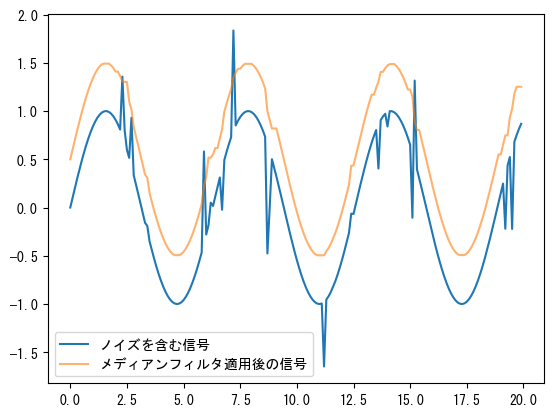

In [2]:
t = np.arange(0, 20, 0.1)
x = np.sin(t)
x[np.random.randint(0, len(t), 20)] += np.random.standard_normal(20) * 0.6  #❶
x2 = signal.medfilt(x, 5)  #❷
x3 = signal.order_filter(x, np.ones(5), 2)
print(np.all(x2 == x3))
plt.plot(t, x, label="ノイズを含む信号")
plt.plot(t, x2 + 0.5, alpha=0.6, label="メディアンフィルタ適用後の信号")
plt.legend(loc="best");

❶まず、ランダムな瞬間ノイズを含む正弦波を作成します。❷次に、`medfilt()`を呼び出してメディアンフィルタを適用します。2番目のパラメータは、メディアンを計算するウィンドウのサイズで、奇数でなければなりません。`medfilt()`は、信号の各要素をそのウィンドウ内のメディアンに置き換えます。
    
最後に、元の信号とフィルタリングされた信号をプロットします。比較を容易にするために、フィルタリングされた信号を0.5だけ上にシフトしています。結果は上のグラフに示されています。メディアンフィルタは、順序フィルタの特殊なケースです。順序フィルタを使用すると、要素をそのウィンドウ内の指定された順序の要素に置き換えることができます。その呼び出し形式は次のとおりです：

    order_filter(a, domain, rank)
    
ここで、`a`は多次元配列、`domain`は`a`と同じ次元数の配列で、ウィンドウの範囲を指定します。`rank`は非負の整数で、ウィンドウ内の要素をソートした後の値を選択します。0は最小値を選択し、1は2番目に小さい値を選択します。メディアンフィルタは`order_filter()`でも計算できますが、`domain`パラメータは長さ5で、すべての値が1の配列であることに注意してください。

## フィルタ設計

`signal`モジュールは、多くのフィルタ設計関数を提供しています。以下の例では、IIRバンドパスフィルタを設計し、その周波数応答を確認し、最後に周波数スイープ信号に対してフィルタリング計算を行います。

In [3]:
sampling_rate = 8000.0

# バンドパスフィルタを設計：
# パスバンドは0.2*4000 - 0.5*4000
# ストップバンドは<0.1*4000, >0.6*4000
# パスバンドの最大減衰値は2dB
# ストップバンドの最小減衰値は40dB
b, a = signal.iirdesign([0.2, 0.5], [0.1, 0.6], 2, 40)  #❶

# freqを使用してフィルタの周波数応答を計算
w, h = signal.freqz(b, a)  #❷

# ゲインを計算
power = 20 * np.log10(np.clip(np.abs(h), 1e-8, 1e100))  #❸
freq = w / np.pi * sampling_rate / 2  #❹

❶まず、`iirdesign()`を使用してIIRバンドパスフィルタを設計します。このフィルタのパスバンドは$0.2 f_0$から$0.5 f_0$で、ストップバンドは$0.1 f_0$未満と$0.6 f_0$より大きい範囲です。ここで、$f_0$は信号のサンプリング周波数の半分です。サンプリング周波数が8kHzの場合、このバンドパスフィルタのパスバンドは800Hzから2kHzです。パスバンドの最大ゲイン減衰は2dBで、ストップバンドの最小ゲイン減衰は40dBです。つまり、パスバンドのゲインは2dB以内で変動し、ストップバンドでは少なくとも40dBの減衰があります。

`iirdesgin()`は、IIRフィルタの分子と分母の係数である2つの配列`b`と`a`を返します。ここで、`a[0]`は常に1です。❷`freqz()`を呼び出して、得られたフィルタの周波数応答を計算します。`freqz()`は2つの配列`w`と`h`を返します。ここで、`w`は円周波数の配列で、$\omega f_0/\pi$を使用して実際の周波数を計算できます。`h`は`w`の対応する周波数点での応答で、複素数の配列です。その絶対値はフィルタのゲイン特性を表し、位相角はフィルタの位相特性を表します。

❸`h`のゲイン特性を計算し、dBで測定します。`h`にはほとんど0に近い値が含まれているため、まず`clip()`でクリップしてから対数関数を呼び出し、計算エラーを回避します。❹次のグラフに示すフィルタのゲイン特性をプロットします。ここでは、サンプリング周波数が8kHzであると仮定しています。
    
実際の応用では、未知のシステムの周波数特性を測定するために、周波数スイープ波をシステムに入力し、システムの出力を観察してその周波数特性を計算することがよくあります。以下では、このプロセスをシミュレートします。

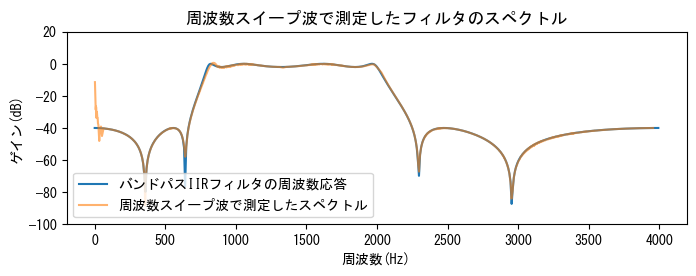

In [4]:
# サンプリング周波数sampling_rate Hzで2秒間の周波数スイープ信号を生成
# 開始周波数は0、終了周波数はsampling_rate/2
t = np.arange(0, 2, 1 / sampling_rate)  #❶
sweep = signal.chirp(t, f0=0, t1=2, f1=sampling_rate / 2)  #❷
# 周波数スイープ信号をフィルタリング
out = signal.lfilter(b, a, sweep)  #❸
# 波形をエネルギーに変換
out = 20 * np.log10(np.abs(out))  #❹
# すべての局所最大値のインデックスを検索
index = signal.argrelmax(out, order=3)  #❺
# フィルタリングされた波形のゲインをプロット
plt.figure(figsize=(8, 2.5))
plt.plot(freq, power, label="バンドパスIIRフィルタの周波数応答")
plt.plot(
    t[index] / 2.0 * 4000,
    out[index],
    label="周波数スイープ波で測定したスペクトル",
    alpha=0.6,
)  #❻
plt.legend(loc="best")

plt.title("周波数スイープ波で測定したフィルタのスペクトル")
plt.ylim(-100, 20)
plt.ylabel("ゲイン(dB)")
plt.xlabel("周波数(Hz)");

❶`chirp()`を呼び出して周波数スイープ波形のデータを生成するために、まずサンプリング時間の等差配列を生成します。ここでは、2秒間のサンプリング周波数8kHzのサンプリング時間配列を生成します。❷次に、`chirp()`を呼び出して2秒間の周波数スイープ波形のデータを取得します。周波数スイープ波の開始周波数`f0`は0Hzで、終了周波数`f1`は4kHzです。4kHzに到達する時間は2秒で、配列`t`をサンプリング時間点として使用します。❸最後に、`lfilter()`を呼び出して、周波数スイープ波形がバンドパスフィルタを通った後の結果を計算します。
    
❹システムのゲイン特性図と比較するために、出力波形の包絡線を取得する必要があります。そのため、まず出力波形データをエネルギー値に変換します。❺包絡線を計算するために、`argrelmax()`を呼び出して`out`配列内のすべての局所最大値のインデックスを検索します。`order`パラメータは局所最大値の範囲を指定し、ここでの値3は、すべての局所最大値が連続する7つの要素（前後3つの要素）の中の最大値であることを意味します。❻最後に、時間を対応する周波数に変換し、すべての局所最大点のエネルギー値をプロットします。
    
上のグラフは、`freqz()`で計算されたスペクトルと周波数スイープ波で得られた周波数特性を示しており、その結果が一致していることがわかります。

## 連続時間線形システム

前節では、`odeint()`を使用して質量-バネ-ダンパ系の微分方程式を数値積分し、PID制御のシミュレーションを行いました。このシステムの微分方程式は次のとおりです：$m \ddot{x} + b \dot{x} + k x = f$。ラプラス変換を使用すると、微分方程式を解きやすい代数方程式に変換できます：$m s^2 X(s) + b s X(s) + k X(s) = F(s)$。ここで、$F(s)$は$f(t)$のラプラス変換、$X(s)$は$x(t)$のラプラス変換であり、$n$次微分は$s^n$になります。$F(s)$は入力信号、$X(s)$は出力信号で、等式を入力/出力の形式に書き換えると、システムの伝達関数$P(s)$が得られます：

$$P(s) = \frac{X(s)}{F(s)} = \frac{1}{m s^2 + b s + k}$$

連続時間システムの伝達関数は、2つの$s$の多項式の商です。連続時間システムの伝達関数を使用すると、特定の入力信号に対する出力信号を簡単に計算できます。以下の例では、`signal`モジュールを使用して、質量-バネ-ダンパ系のステップ信号および正弦波信号に対する応答出力を計算します。❶`lti`オブジェクトを作成します。制御理論では、連続時間線形システムを表すためにさまざまな形式を使用できますが、ここでは伝達関数の分子と分母の多項式の係数を使用します。多項式の係数は`numpy.poly1d`の規則に従います。つまり、インデックス0の要素が最高次の係数です。❷`lti.step()`メソッドを呼び出して、システムのステップ応答を計算します。`T`パラメータは応答を計算する時間配列です。❸`signal.lsim()`を呼び出して、システムの正弦波信号に対する応答を計算します。最初のパラメータは`lti`オブジェクトで、`(numerator, denominator)`を直接渡すこともできます。`U`パラメータは入力信号を保存する配列です。`step()`と`lsim()`の計算結果の2番目の要素はシステムの出力信号で、ここでは他の出力は無視します。

次のグラフは、ステップ応答が最終的に$x=0.05$で安定することを示しており、このとき$k x = 1$です。

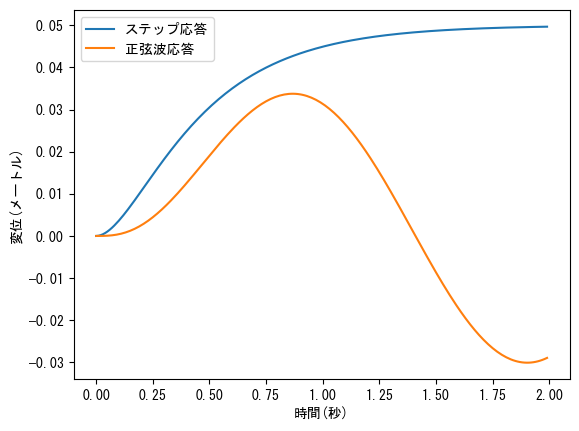

In [5]:
m, b, k = 1.0, 10, 20

numerator = [1]
denominator = [m, b, k]

plant = signal.lti(numerator, denominator)  #❶

t = np.arange(0, 2, 0.01)
_, x_step = plant.step(T=t)  #❷
_, x_sin, _ = signal.lsim(plant, U=np.sin(np.pi * t), T=t)  #❸

plt.plot(t, x_step, label="ステップ応答")
plt.plot(t, x_sin, label="正弦波応答")
plt.legend(loc="best")
plt.xlabel("時間(秒)")
plt.ylabel("変位(メートル)");

伝達関数の代数演算を使用すると、複数の連続時間システムで構成されるシステムを表すことができます。たとえば、2つのシステムのカスケード接続の伝達関数は、各システムの伝達関数の積です。伝達関数は分子と分母の2つの多項式で構成されるため、伝達関数の四則演算はNumPyの`poly1d`関連の関数を使用して実装できます。以下の`SYS`クラスは、`__mul__`、`__add__`、`__sadd__`、`__div__`などのマジックメソッドを定義することで、四則演算をサポートします。

![フィードバック制御システムのブロック図](images/feedback_system.png)

❶`feedback()`メソッドは、対応するフィードバックシステムの伝達関数を計算します。上のグラフでは、$P$は制御対象のシステム、$C$はコントローラで、$C$の入力信号は目標信号と実際の入力の差$x_r - x$です。$x_r$から$x$への伝達関数は、このフィードバックシステムの伝達関数です。図に従って、以下のラプラス変換後の代数方程式を立てることができます：

$$X(s) = (X_r(s) - X(s)) \cdot C(s) \cdot P(s)$$

整理すると：

$$\frac{X(s)}{X_r(s)} = \frac{C(s) \cdot P(s)}{1 + C(s) \cdot P(s)}$$

$C(s) \cdot P(s)$をシステム$Y(s)$と見なすと、フィードバックシステムの伝達関数は次のようになります：$\frac{Y(s)}{1 + Y(s)}$。

❷`SYS`オブジェクトが`step()`、`lsim()`などの関数の最初のシステムパラメータとして使用できるようにするために、`__iter__()`マジックメソッドを定義して、伝達関数の分子と分母の多項式係数を返します。

In [6]:
from numbers import Real


def as_sys(s):
    if isinstance(s, Real):
        return SYS([s], [1])
    return s


class SYS(object):
    def __init__(self, num, den):
        self.num = num
        self.den = den

    def feedback(self):  #❶
        return self / (self + 1)

    def __mul__(self, s):
        s = as_sys(s)
        num = np.polymul(self.num, s.num)
        den = np.polymul(self.den, s.den)
        return SYS(num, den)

    def __add__(self, s):
        s = as_sys(s)
        den = np.polymul(self.den, s.den)
        num = np.polyadd(np.polymul(self.num, s.den), np.polymul(s.num, self.den))
        return SYS(num, den)

    def __sadd__(self, s):
        return self + s

    def __truediv__(self, s):
        s = as_sys(s)
        return self * SYS(s.den, s.num)

    def __iter__(self):  #❷
        return iter((self.num, self.den))

以下では、`SYS`クラスを使用して、PIコントローラで質量-バネ-ダンパーシステムを制御する際のステップ応答を計算します。PIコントローラの伝達関数は次のとおりです：

$$C = \frac{K_p s + K_i}{s} $$

前節で紹介したPIコントローラは離散時間であり、積分器の出力を近似するためにアキュムレータを使用していました。しかし、本節では連続時間システムのシステム応答を使用して制御システムをシミュレートします。

❶質量-バネ-ダンパーシステムの伝達関数を`plant`とし、❷PIコントローラの伝達関数を`pi_ctrl`とします。`step()`が`LinAlgError`例外をスローしないようにするため、PIコントローラの伝達関数の分母の定数項を非常に小さな値に設定します。❸フィードバックシステムの伝達関数`feedback`を計算します。次のグラフからわかるように、$K_i$が0の場合、システムの出力変位と目標変位の間に一定の差があります。$K_p$が大きくなるほど差は小さくなりますが、オーバーシュートが発生します。$K_p$と$K_i$を適切に調整することでオーバーシュートを軽減できますが、目標変位を超える瞬間が依然として存在します。

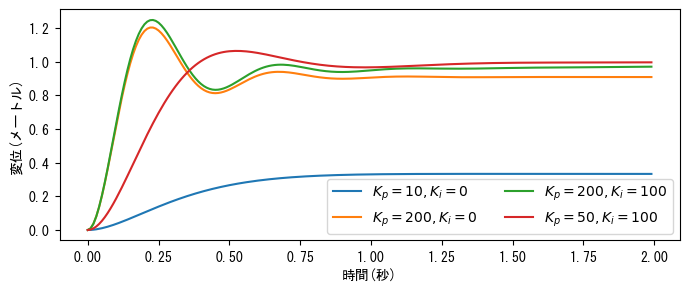

In [7]:
M, b, k = 1.0, 10, 20
plant = SYS([1], [M, b, k])  #❶

pi_settings = [(10, 1e-10), (200, 1e-10), (200, 100), (50, 100)]

fig, ax = plt.subplots(figsize=(8, 3))

for pi_setting in pi_settings:
    pi_ctrl = SYS(pi_setting, [1, 1e-6])  #❷
    feedback = (pi_ctrl * plant).feedback()  #❸
    _, x = signal.step(feedback, T=t)
    label = "$K_p={:d}, K_i={:3.0f}$".format(*pi_setting)
    ax.plot(t, x, label=label)

ax.legend(loc="best", ncol=2)
ax.set_xlabel("時間(秒)")
ax.set_ylabel("変位(メートル)");

質量に加えられる制御力を計算するために、誤差信号を`lsim()`に渡してコントローラの出力を計算できます：

In [8]:
_, f, _ = signal.lsim(pi_ctrl, U=1 - x, T=t)

オーバーシュートを完全に除去するためには、PID制御を使用する必要があります。PIDコントローラの伝達関数は次のとおりです：

$$C = \frac{K_d s^2 + K_p s + K_i}{s} $$

以下では、PIDコントローラで構成されたフィードバックシステムのステップ応答を計算します。PIDコントローラは入力信号を微分する必要があるため、ステップ入力信号はPIDの出力にパルス出力、つまり時間が無限に短く、値が無限に大きい信号を含むことになります。

In [9]:
kd, kp, ki = 30, 200, 400
pid_ctrl = SYS([kd, kp, ki], [1, 1e-6])
feedback = (pid_ctrl * plant).feedback()
_, x2 = signal.step(feedback, T=t)

PIDコントローラの出力を限定された範囲内に収めるために、フィードバックシステムの前にローパスフィルタを追加できます。一次ローパスフィルタの伝達関数は次のとおりです：$\frac{1}{a \cdot s + 1}$。ローパスフィルタを追加すると、PIDコントローラの入力は連続信号になります。

![ローパスフィルタを備えたフィードバック制御システムのブロック図](images/feedback_system_lp.png)

In [10]:
lp = SYS([1], [0.2, 1])
lp_feedback = lp * (pid_ctrl * plant).feedback()
_, x3 = signal.step(lp_feedback, T=t)

PIDコントローラの伝達関数の分子の次数が分母の次数よりも高いため、`lsim()`を使用してその応答を計算することはできません。$x_r$をシステムの入力、$f$を出力とし、以下の方程式を使用して$x_r$から$f$への伝達関数を計算できます：

$$ F(s) = (X_r(s) \cdot LP(s) - F(s) \cdot P(s)) \cdot C(s)$$

伝達関数は次のようになります：

$$\frac{F(s)}{X_r(s)} = \frac{C(s) \cdot LP(s)}{C(s) \cdot P(s) + 1}$$

以下では、上記の式に基づいてローパスフィルタを備えた制御システムにおけるコントローラの出力を計算します：

In [11]:
pid_out = (pid_ctrl * lp) / (pid_ctrl * plant + 1)
_, f3 = signal.step(pid_out, T=t)

次のグラフは、上記のPI制御、PID制御、およびローパスフィルタを備えたPID制御などのシステムにおけるスライダの変位および制御力を示しています。PID制御の制御力にはパルス信号が含まれるため、図に正しく表示することはできません。変位曲線から、ローパス+PID制御のローパスフィルタがオーバーシュートを効果的に抑制できることがわかります。

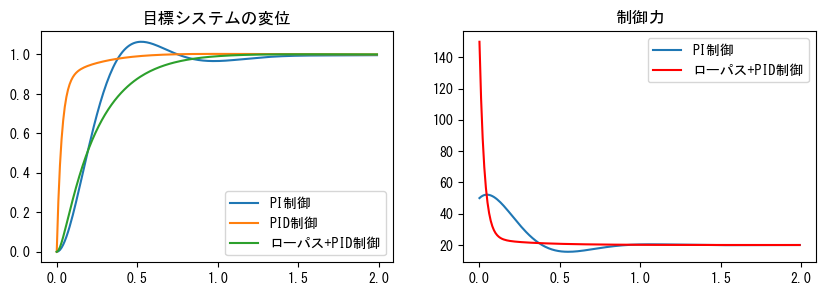

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(t, x, label="PI制御")
ax1.plot(t, x2, label="PID制御")
ax1.plot(t, x3, label="ローパス+PID制御")
ax2.plot(t, f, label="PI制御")
ax2.plot(t, f3, color="r", label="ローパス+PID制御")
ax1.legend(loc="best")
ax2.legend(loc="best")
ax1.set_title("目標システムの変位")
ax2.set_title("制御力");